<a href="https://colab.research.google.com/github/AamirKhaan/Student-Academic-Performance/blob/master/11_Bagging_DecisionTreeClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 style="background-color:Aqua; padding:20px; border-radius:10px">Bagging with Decision Tree Classifier</h1>

## Overview      

<div style="background-color:Gainsboro; padding:20px; text-align:justify; font-weight: bold">
    <p>In this section following steps are performed: </p>
    <ol>
        <li>Data Preparation and Encoding</li>
        <li>Preliminary Bagging DT Classifier</li>
        <li>Bagging DT Classifier Optimization with Number of estimators</li>
        <li>Bagging DT Classifier with optimized Number of estimators</li>
        <li>Repeated Stratified k-Fold Cross Validation</li>
        <li>Model Learning Curve</li>
    </ol>
</div>


### Standard Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder

from sklearn.ensemble import BaggingClassifier

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

In [2]:
# Jupyter Noteboook Configurations (personal prefrences)
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
pd.set_option('display.max_columns', None)
sns.set() 

In [3]:
# Global parameters for figure
plt.rcParams["figure.figsize"] = [10.00, 8.00]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.autolayout"] = True

### 1. Data Preparation and Encoding

#### 1.1 Import Modified Data

In [4]:
# Import the Student's data from local storage
# ! Dont' run the cell in colab
data_df = pd.read_csv('./data/xAPI-Edu-Data_modified.csv')

In [5]:
# Import the Student's data from github storage
# Run only in colab
url = 'https://raw.githubusercontent.com/AamirKhaan/Student-Academic-Performance/main/data/xAPI-Edu-Data_modified.csv'
data_df = pd.read_csv(url)

In [6]:
# Selected Features
CATEGORICAL_FEATURES = ['stage_id','relation', 'parent_answering_survey', 
                            'parent_school_satisfaction','student_absence_days']
NUMERICAL_FEATURES = ['raised_hands', 'visited_resources', 'announcements_view', 'discussion']
TARGET = ['class']

In [7]:
# Optimize Data Type for efficent memory utilization
for feature in CATEGORICAL_FEATURES:
    data_df[feature] = data_df[feature].astype('category')
    
for feature in NUMERICAL_FEATURES:
    data_df[feature] = data_df[feature].astype('int8')

data_df[TARGET] = data_df[TARGET].astype('category')

#### 1.2 Encode Data

In [8]:
# Input Features Encoding
categorical_encoder = OrdinalEncoder(dtype='int8')
categorical_ds  = categorical_encoder.fit_transform(data_df[CATEGORICAL_FEATURES])
categorical_encoded = pd.DataFrame(categorical_ds, columns=CATEGORICAL_FEATURES, dtype='int8')
# Target Encoding
target_encoder = LabelEncoder()
target_ds = target_encoder.fit_transform(data_df[TARGET])
target_encoded = pd.DataFrame(target_ds, columns=TARGET, dtype='int8')
# Combine the Data
encoded_df = pd.concat([categorical_encoded,data_df[NUMERICAL_FEATURES]], axis=1)

### 2.  Preliminary Bagging DT Classifier

In [9]:
X = encoded_df
y = target_encoded

In [10]:
# Test train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [11]:
# Bagging Classifier
clf = BaggingClassifier(random_state=42)

#### 2.1 Model Parameters

In [12]:
# Model parameters
clf.get_params()

{'base_estimator': None,
 'bootstrap': True,
 'bootstrap_features': False,
 'max_features': 1.0,
 'max_samples': 1.0,
 'n_estimators': 10,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [13]:
# Train the model
clf = clf.fit(X_train, y_train)

#### 2.3 Model Scores

In [15]:
# Test Accuracy
y_hat = clf.predict(X_test)
initial_test_accuracy = accuracy_score(y_test, y_hat)
print(f'Preliminary Bagging DT Classifier Test Accuracy: {initial_test_accuracy*100}')
# Train Accuracy
predictions_train = clf.predict(X_train)
initial_train_accuracy = accuracy_score(y_train, predictions_train)
print(f'Preliminary Bagging DT Classifier Train Accuracy: {initial_train_accuracy*100}')

Preliminary Bagging DT Classifier Test Accuracy: 73.41772151898735
Preliminary Bagging DT Classifier Train Accuracy: 96.25


<div style="background-color:Gainsboro; padding:20px; text-align:justify; ">
<p>The accuracy of the model on Training Data (96.25%) and the accuracy on Test Data (73.41%).</p>
</div>

#### 2.4 Confusion Matrix

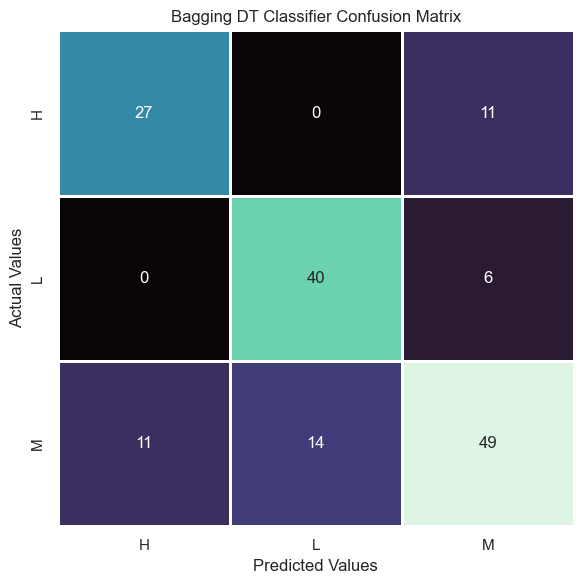

In [16]:
cm_df = pd.DataFrame(confusion_matrix(y_test, y_hat),
                     index = ['H','L','M'], 
                     columns = ['H','L','M'])

fig = plt.figure(figsize=(6,6))
sns.heatmap(cm_df, annot=True, cmap='mako',cbar=False,linewidth=1)
plt.title('Bagging DT Classifier Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

#### 2.5 Classification Report

In [17]:
print('Bagging DT Classifier Report\n')
print(classification_report(y_test,y_hat, target_names=['H','L','M']))

Bagging DT Classifier Report

              precision    recall  f1-score   support

           H       0.71      0.71      0.71        38
           L       0.74      0.87      0.80        46
           M       0.74      0.66      0.70        74

    accuracy                           0.73       158
   macro avg       0.73      0.75      0.74       158
weighted avg       0.73      0.73      0.73       158



### 3. Bagging DT Classifier Optimization with Number of estimators

In [18]:
n_estimators = np.arange(10,110,10)

clf_bagging = []
for n in n_estimators :
    clf = BaggingClassifier(n_estimators = n, random_state=42)
    clf.fit(X_train, y_train)
    clf_bagging.append(clf)

train_scores = [clf.score(X_train,y_train) for clf in clf_bagging]
test_scores = [clf.score(X_test,y_test) for clf in clf_bagging]

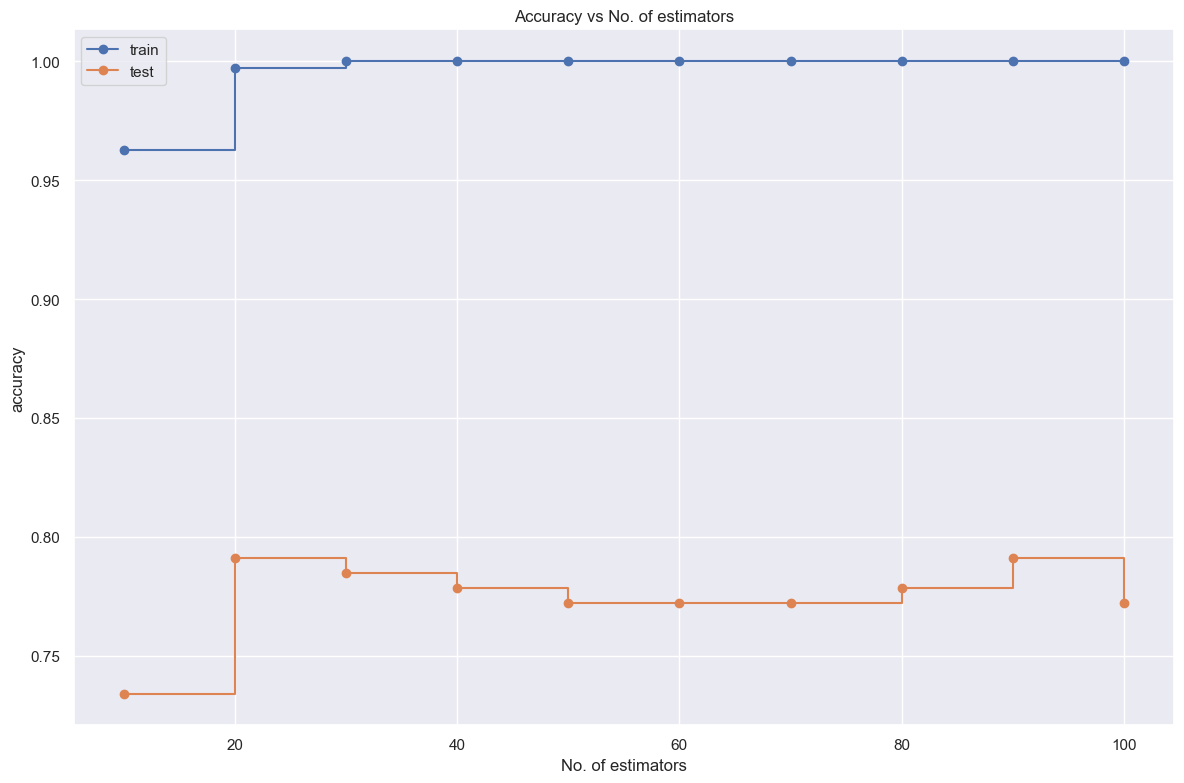

In [19]:
plt.rcParams["figure.figsize"] = [12.00, 8.00]
fig, ax = plt.subplots()
ax.set_xlabel('No. of estimators')
ax.set_ylabel('accuracy')
ax.set_title('Accuracy vs No. of estimators')
ax.plot(n_estimators , train_scores, marker='o', label='train', drawstyle='steps-post')
ax.plot(n_estimators , test_scores, marker='o', label='test', drawstyle='steps-post')
ax.legend()
plt.show()

<div style="background-color:Gainsboro; padding:20px; text-align:justify;">
<p>The graph of accuracy vs No. of estimators show the variation in the accuracy with respect to No. of estimators in Training and Test data. The highest accuracy in test data is when the number of estimators are 20.</p>
</div>

In [20]:
# Get the index of the peak accuracy on the test data
index_max = test_scores.index(max(test_scores))

### 4. Bagging DT Classifier with optimized Number of estimators

#### 4.1 Optimized Bagging DT Classifier Parameters

In [21]:
clf_bagging[index_max].get_params()

{'base_estimator': None,
 'bootstrap': True,
 'bootstrap_features': False,
 'max_features': 1.0,
 'max_samples': 1.0,
 'n_estimators': 20,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

#### 4.2 Optimized Bagging DT Classifier Scores

In [22]:
# Test Accuracy
opt_y_test = clf_bagging[index_max].predict(X_test)
opt_test_accuracy = accuracy_score(y_test, opt_y_test)
print(f'Optimized MLR Test Accuracy: {opt_test_accuracy*100}')
# Train Accuracy
opt_y_train = clf_bagging[index_max].predict(X_train)
opt_train_accuracy = accuracy_score(y_train, opt_y_train)
print(f'Optimized MLR  Train Accuracy: {opt_train_accuracy*100}')

Optimized MLR Test Accuracy: 79.11392405063292
Optimized MLR  Train Accuracy: 99.6875


<div style="background-color:Gainsboro; padding:20px; text-align:justify; ">
<p>The accuracy of the optimized model on Training Data (99.69%) greater than the accuracy on Test Data (79.11%). The model shows acceptable performance. </p>
</div>

#### 4.3 Optimized Bagging DT Classifier Confusion Matrix

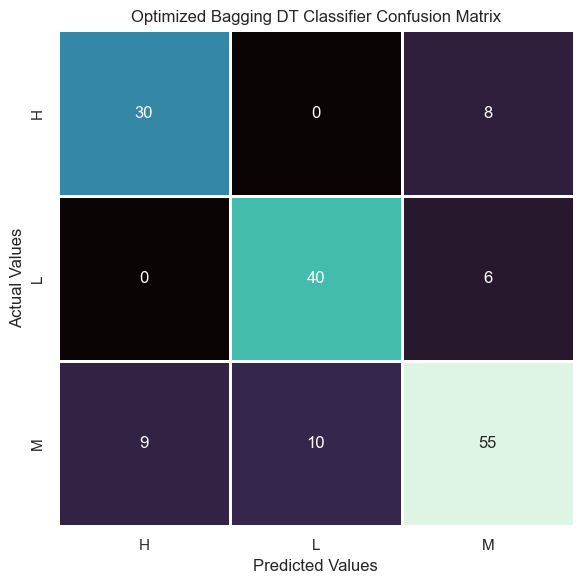

In [28]:
ocm_df = pd.DataFrame(confusion_matrix(y_test, opt_y_test),
                     index = ['H','L','M'], 
                     columns = ['H','L','M'])

fig = plt.figure(figsize=(6,6))
sns.heatmap(ocm_df, annot=True, cmap='mako',cbar=False,linewidth=1)
plt.title('Optimized Bagging DT Classifier Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

#### 4.4 Optimized Bagging DT Classification report

In [24]:
print('Optimized Bagging DT Classifier Report\n')
print(classification_report(y_test,opt_y_test, target_names=['H','L','M']))

Optimized Bagging DT Classifier Report

              precision    recall  f1-score   support

           H       0.77      0.79      0.78        38
           L       0.80      0.87      0.83        46
           M       0.80      0.74      0.77        74

    accuracy                           0.79       158
   macro avg       0.79      0.80      0.79       158
weighted avg       0.79      0.79      0.79       158



### 5. Repeated Stratified k-Fold Cross Validation

In [25]:
# Model
clf_cv = BaggingClassifier(n_estimators = 20, random_state=42)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

scores = cross_val_score(clf_cv, X_train, y_train, scoring='accuracy', cv = cv, n_jobs=-1)

# Performance
print('Mean Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

Mean Accuracy: 0.740 (0.054)


### 6. Model Learning Curve

In [26]:
cv = ShuffleSplit(n_splits=50, test_size=0.2, random_state=42)
estimator = BaggingClassifier(n_estimators = 20, random_state=42)

train_sizes=np.linspace(0.1, 1.0, 5)

train_sizes, train_scores, test_scores, fit_times, score_times = learning_curve(
        estimator,
        X,
        y,
        cv=cv,
        n_jobs=-1,
        train_sizes=train_sizes,
        return_times=True,
    )

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

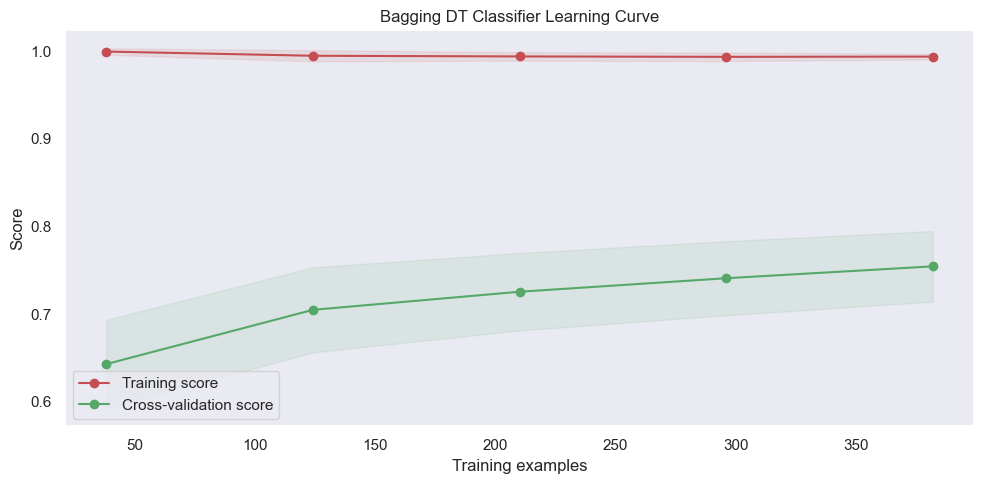

In [27]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_title('Bagging DT Classifier Learning Curve')
ax.set_xlabel("Training examples")
ax.set_ylabel("Score")
# Plot learning curve
ax.grid()
ax.fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",)

ax.fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",)
    
ax.plot(train_sizes, train_scores_mean, "o-", color="r", label="Training score")   
ax.plot(train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score")   
ax.legend(loc="best");

## Observations
  
The key observations are:  
   
1. The Preliminary Bagging DT Classifier has:     
    a. Test Accuracy of 73.42%     
    b. Train Accuracy of 96.25%     
2. Optimization by varying number of esimators (20) results in highest accuracy of 79.11%.
3. The Optimized Bagging DT Classifier has:   
    a. Test Accuracy of 79.11%     
    b. Train Accuracy of 99.69%    
4. The 10 Fold Cross Validation fo the Base Decision Tree relusted in Mean Accuracy of 74%.

## Conclusion
Based on the obervations:

1. The Optimized Bagging DT Classifier produced the maximum test accuracy of 79.11%.
2. The Cross Validation produced mean accuracy of 74% that show the model is quite well trained and have acceptable performance.